# Imports

In [5]:
import os
import cv2
import numpy as np
import pandas as pd
from time import time
from PIL import Image
from random import randint
import matplotlib.pyplot as plt

# Loading Dataset (Image Paths) and Labels

In [6]:
img_sz = 224

def preprocess_image(img, size_threshold = img_sz):
    s1, s2, _ = np.array(img).shape
    x_scaling_factor = size_threshold / s2
    y_scaling_factor = size_threshold / s1
    
    img = cv2.resize(img, dsize=(0, 0), fx=x_scaling_factor, fy=y_scaling_factor)
    return img

In [7]:
dir1 = './datasets/simple_clocks/analog_clocks/images/'
dir2 = './datasets/simple_clocks/simple_analog_clock_monochrome/clock_minute_hand/samples/'

In [8]:
df1 = pd.read_csv('./datasets/simple_clocks/analog_clocks/label.csv')
filepaths = [dir1 + f'{i}.jpg' for i in range(50000)]
df1.insert(0, "path", filepaths)
df1['hour'] = df1['hour'].astype(np.int32)
df1['minute'] = df1['minute'].astype(np.int32)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    50000 non-null  object
 1   hour    50000 non-null  int32 
 2   minute  50000 non-null  int32 
dtypes: int32(2), object(1)
memory usage: 781.4+ KB


In [9]:
df2 = pd.DataFrame(columns=['path', 'hour', 'minute'], index=range(10000))
for i, filename in enumerate(os.listdir(dir2)):
    path = dir2 + filename
    labels = filename.split('.')[0].split('_')
    hr, minute = labels[1], labels[2]
    df2.loc[i]  = [path, hr, minute]

df2['hour'] = df2['hour'].astype(np.int32)
df2['minute'] = df2['minute'].astype(np.int32)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    10000 non-null  object
 1   hour    10000 non-null  int32 
 2   minute  10000 non-null  int32 
dtypes: int32(2), object(1)
memory usage: 156.4+ KB


# Utility Functions and Thresholds

In [10]:
def random_delta(idx = -1):
    return (randint(0, 1e3) * 1e-3) + (randint(0, 1e5) * 1e-5) + (randint(0, 1e7) * 1e-7) + (idx * 1e-6)

In [11]:
def select_useful_lines(lines, center, radius, threshold = 0.30, idx = -1):
    n = len(lines)

    useful = []
    x0, y0 = center

    if n == 1 or n == 2:
        for i in range(n):
            line = lines[i][0]
            y1, x1, y2, x2 = line
            len1 = np.linalg.norm([x2-x1, y2-y1]) + random_delta(idx)

            # appending length, line
            useful.append([len1, line])

        return sorted(useful)

    for i in range(n):
        x1, y1, x2, y2 = lines[i][0]


        # calculating as if one straight line
        # distance_bw_center_and_line = abs((x2-x1)*(y0-y1) - (x0-x1)*(y2-y1)) / np.linalg.norm([x2-x1, y2-y1])

        # calculating dist of center from start and end points of line segment
        d1 = np.linalg.norm([x1-x0, y1-y0])
        d2 = np.linalg.norm([x2-x0, y2-y0])
        distance_bw_center_and_line = min(d1, d2)

        # print("dist: ", distance_bw_center_and_line)
        if distance_bw_center_and_line <= radius * threshold:
            useful.append(lines[i][0])

    lines = np.array(useful)
    # print("first round useful: ", lines)
    n = len(lines)
    indices_added = []

    slope_dict = {}

    for i in range(n):
        y1, x1, y2, x2 = lines[i]

        len1 = np.linalg.norm([x2-x1, y2-y1]) + random_delta(idx)

        if len1 > radius:
            continue

        if abs(x2-x1) < 1e-5:
            slope = 1e5
        else:
            slope = (y2-y1) / (x2-x1)

        theta = np.arctan(slope)
        theta_in_deg = int(theta * 180/np.pi)

        if theta_in_deg%10 in [0, 1, 2, 3, 4]:
            theta_nearest_10 = theta_in_deg - (theta_in_deg%10)
        else:
            theta_nearest_10 = theta_in_deg - (theta_in_deg%10) + 10

        if theta_nearest_10 in slope_dict:
            slope_dict[theta_nearest_10].append([len1, lines[i]])
        else:
            slope_dict[theta_nearest_10] = [[len1, lines[i]]]


    for theta_nearest_10 in slope_dict:
        slope_dict[theta_nearest_10].sort(reverse=True)
    
    useful = []
    for theta_nearest_10 in slope_dict:
        line = slope_dict[theta_nearest_10][0][1]
        y1, x1, y2, x2 = line
        len1 = np.linalg.norm([x2-x1, y2-y1])

        # appending length, line
        useful.append([len1, line])
    
    n = len(useful)

    # sorting
    for i in range(n):
        for j in range(i+1, n):
            if useful[i][0] >= useful[j][0]:
                useful[i], useful[j] = useful[j], useful[i]

    return useful


In [12]:
def find_intersection_of_lines(l1, l2, center):
    x1, y1, x2, y2 = l1
    x3, y3, x4, y4 = l2

    num_x = (x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4)
    den_x = (x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4)

    num_y = (x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4)
    den_y = (x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4)

    if abs(den_x) < 1e-10 or abs(den_y) < 1e-10:
        # print(den_x, den_y)
        return np.array(center)
    
    return np.array([num_x / den_x, num_y / den_y])



In [13]:
# assuming 12 o clock is vertically upwards for now

def angle_from_vertical(line, center):
    center = np.array([center[1], center[0]])
    y1, x1, y2, x2 = np.int32(line)
    slope = None
    angle = None

    far_from_center = np.array([x1, y1])

    if np.linalg.norm([center[0]-x2, center[1]-y2]) > np.linalg.norm([center[0]-x1, center[1]-y1]):
        far_from_center = np.array([x2, y2])
    
    difference = far_from_center - center

    # print("far_from_center: ", far_from_center)

    a, b = difference
    # print("difference: ", difference)
    quad = 1
    
    if a>0 and b>0: quad = 1
    if a<0 and b>0: quad = 2
    if a<0 and b<0: quad = 3
    if a>0 and b<0: quad = 4

    # print("quad: ", quad)

    if abs(x2-x1) < 1e-5:
        #handle vertical line
        # if quad == 1 or quad == 4: return 0
        # if quad == 2 or quad == 3: return 180
        if quad == 1 or quad == 2: return 90
        if quad == 4 or quad == 3: return 270

    else:
        slope = (y2-y1) / (x2-x1)
        # print(f"slope: {slope}")

        if slope == 0:
            if abs(difference[0]) > abs(difference[1]):
                # print(difference)
                return 0
            else:
                return 180


        angle = np.arctan(slope)
        if angle < 0: angle += np.pi

        angle_in_deg = (angle) * (180/np.pi)

        # print("angle_in_deg: ", angle_in_deg)

        if quad == 1:
            return 180 - angle_in_deg

        if quad == 2:
            return 180 - angle_in_deg
        
        if quad == 3:
            return 360 - angle_in_deg
        
        return 360 - angle_in_deg


In [14]:
def calc_time(angle_hour, angle_min):
    angle_hour, angle_min = int(angle_hour), int(angle_min)
    hour = angle_hour // 30
    minutes = angle_min // 6

    # lies close to hour marker
    if angle_hour%30 <= 5 and (60 - minutes) <= 20 and hour>0:
        hour -= 1

    if angle_hour%30 >= 25 and (minutes) <= 20:
        hour = (hour + 1) % 12

    return hour, minutes

# Testing

In [15]:
df = df1

dfidx = 428
df.iloc[dfidx]['path']

'./datasets/simple_clocks/analog_clocks/images/428.jpg'

In [16]:
img_name = df['path'].iloc[dfidx]

img_orig = cv2.imread(img_name)
img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
img_orig = preprocess_image(img_orig)
cimg = img_orig.copy()
img = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)


circle_radius = -1
selected_circle = None

for r in range(img_sz//20, img_sz//2):
    circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,10,param1=20,param2=20,minRadius=r,maxRadius=r)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0,:]:
            if i[2] > circle_radius:
                circle_radius = i[2]
                selected_circle = i


if selected_circle is not None:
    cv2.circle(cimg,(selected_circle[0],selected_circle[1]),selected_circle[2],(255,0,0),2)
    cv2.circle(cimg,(selected_circle[0],selected_circle[1]),2,(0,0,255),3)

print(selected_circle)

[134 138  72]


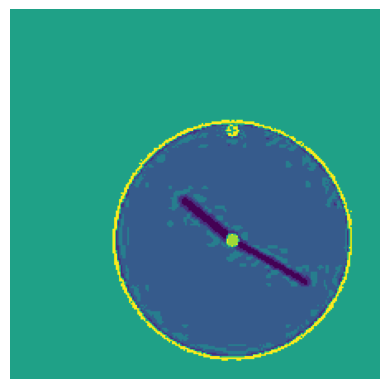

In [17]:
# segmentation: kmeans
# n_clusters = 8

Z = img_orig.reshape((-1,3))
Z = np.float32(Z)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 8
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img_orig.shape))

plt.axis("off")
plt.imshow(label.reshape((img_orig.shape[0:2])))

In [18]:
max_lines = []
min_line_length = selected_circle[2] * 0.1
params = None

# for canny_t1 in range(1, 255, 2):
#     for canny_t2 in range(1, 255, 2):
#         for th in range(50, 40, -1):
#             dst = cv2.Canny(img, canny_t1, canny_t2, 3)
#             linesP = cv2.HoughLinesP(dst, 1, np.pi / 180, th, None, min_line_length, 10)

#             if linesP is not None:
#                 # print(linesP)
#                 if len(linesP) > len(max_lines):
#                     print("found: ", len(linesP))
#                     max_lines = linesP
#                     params = [canny_t1, canny_t2, th]

canny_t1 = 85
canny_t2 = 255
hough_th = 22

dst = cv2.Canny(res2, canny_t1, canny_t2)
linesP = cv2.HoughLinesP(dst, 1, np.pi / 180, hough_th, None, min_line_length, 10)

if linesP is not None:
    if len(linesP) > len(max_lines):
        print("found: ", len(linesP))
        max_lines = linesP


found:  13


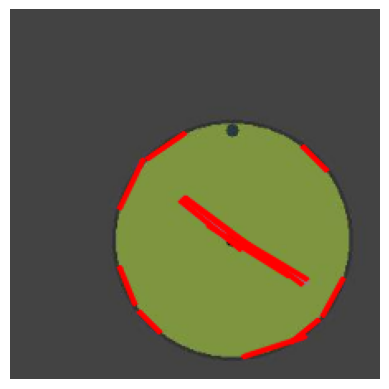

In [19]:
cdst = img_orig.copy()

for i in range(0, len(max_lines)):
    l = max_lines[i][0]
    cv2.line(cdst, (l[0], l[1]), (l[2], l[3]), (255,0,0), 2, cv2.LINE_AA)

plt.axis("off")
plt.imshow(cdst)

[[50.0, array([105, 114, 145, 144], dtype=int32)], [56.60388679233962, array([120, 131, 168, 161], dtype=int32)]]


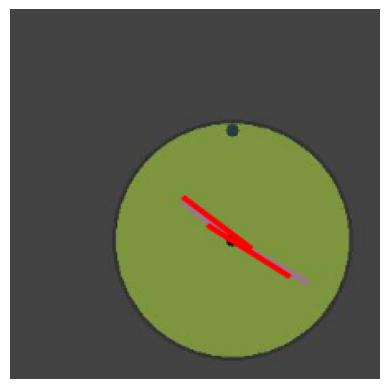

In [20]:
useful_lines = select_useful_lines(max_lines, center=selected_circle[0:2], radius=selected_circle[2])
print(useful_lines)
cdst2 = img_orig.copy()

clrs = [(255, 0, 0), (255, 0, 255), (255, 255, 255)]

for i in range(0, len(useful_lines)):
    l = useful_lines[i][1]
    cv2.line(cdst2, (l[0], l[1]), (l[2], l[3]), clrs[0], 2, cv2.LINE_AA)

plt.axis("off")
plt.imshow(cdst2)

In [21]:
mn_idx, mx_idx = 0, -1
radius = selected_circle[2]
center = selected_circle[0:2]

center_dist_threshold = radius * 0.3
closest_to_center = 1e5

n = len(useful_lines)

for i in range(n):
    for j in range(i+1, n):
        l1 = useful_lines[j][1]
        l2 = useful_lines[i][1]

        ints_point = find_intersection_of_lines(l1, l2, center)
        dist = np.linalg.norm(ints_point - center)
        print(i, j, ints_point, dist)

        if dist < closest_to_center:
            closest_to_center = dist
            mn_idx = i
            mx_idx = j

mn_idx, mx_idx, closest_to_center

0 1 [166.   159.75] 38.69189191549051


(0, 1, 38.69189191549051)

In [22]:
angle_hour = angle_from_vertical(useful_lines[mn_idx][1], center)
angle_min = angle_from_vertical(useful_lines[mx_idx][1], center)

print(angle_hour, angle_min)
time_op = calc_time(angle_hour, angle_min)

print("\n\n")
print("Time Calculated       :", time_op)
print("Time Labelled (actual):", tuple(df[['hour', 'minute']].iloc[dfidx]))
# print(df[['hour', 'minute']].iloc[dfidx])

306.86989764584405 122.0053832080835



Time Calculated       : (10, 20)
Time Labelled (actual): (10, 20)


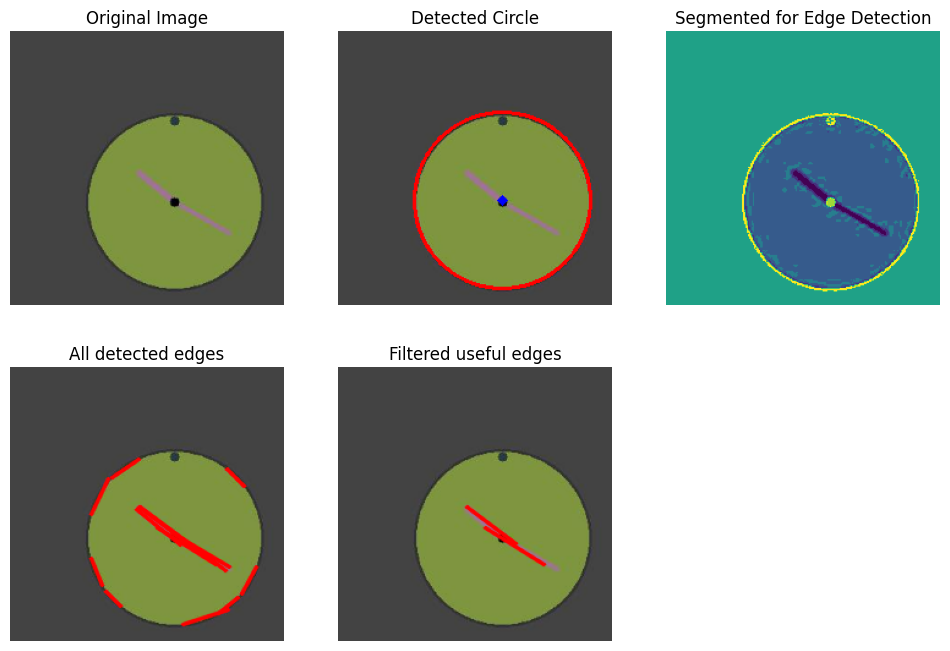

In [23]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.axis("off")
plt.title("Original Image")
plt.imshow(img_orig)

plt.subplot(2, 3, 2)
plt.axis("off")
plt.title("Detected Circle")
plt.imshow(cimg)

plt.subplot(2, 3, 3)
plt.axis("off")

# plt.title("Grayscale for Edge Detection")
# plt.imshow(cv2.cvtColor(res2, cv2.COLOR_RGB2GRAY), cmap='gray')

plt.title("Segmented for Edge Detection")
plt.imshow(label.reshape((img_orig.shape[0:2])))


plt.subplot(2, 3, 4)
plt.axis("off")
plt.title("All detected edges")
plt.imshow(cdst)

plt.subplot(2, 3, 5)
plt.axis("off")
plt.title("Filtered useful edges")
plt.imshow(cdst2)

plt.show()

# Metrics

In [24]:
def time_difference_in_minutes(h1, m1, h2, m2):
    total_minutes_1 = h1 * 60 + m1
    total_minutes_2 = h2 * 60 + m2
    time_difference = abs(total_minutes_1 - total_minutes_2)
    
    return time_difference


In [25]:
def predict_time_1(img_name, idx, use_kmeans=False):
    result = [-1, -1]

    img_orig = cv2.imread(img_name)
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    img_orig = preprocess_image(img_orig)
    cimg = img_orig.copy()
    img = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)


    circle_radius = -1
    selected_circle = None

    for r in range(img_sz//20, img_sz//2):
        circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,10,param1=20,param2=20,minRadius=r,maxRadius=r)

        if circles is not None:
            circles = np.uint16(np.around(circles))
            for i in circles[0,:]:
                if i[2] > circle_radius:
                    circle_radius = i[2]
                    selected_circle = i

    if selected_circle is None: return result
    # selected_circle[1] -= selected_circle[1] * 0.2

    max_lines = []
    min_line_length = selected_circle[2] * 0.1
    params = None

    if use_kmeans:
        Z = img_orig.reshape((-1,3))
        Z = np.float32(Z)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        K = 8
        ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
        center = np.uint8(center)
        res = center[label.flatten()]
        img = res.reshape((img_orig.shape))
        # img = res2


    canny_t1 = 85
    canny_t2 = 255
    hough_th = 25

    # dst = cv2.Canny(img, canny_t1, canny_t2)
    dst = cv2.Canny(img, canny_t1, canny_t2) # using the kmeans output
    
    linesP = cv2.HoughLinesP(dst, 1, np.pi / 180, hough_th, None, min_line_length, 10)

    if linesP is None or len(linesP) == 0: return result

    # print("found: ", len(linesP))
    max_lines = linesP
    useful_lines = select_useful_lines(max_lines, center=selected_circle[0:2], radius=selected_circle[2], idx=idx)

    mn_idx, mx_idx = 0, -1
    radius = selected_circle[2]
    center = selected_circle[0:2]

    center_dist_threshold = radius * 0.3
    closest_to_center = 1e5

    n = len(useful_lines)

    if n == 0: return result

    for i in range(n):
        for j in range(i+1, n):
            l1 = useful_lines[j][1]
            l2 = useful_lines[i][1]

            ints_point = find_intersection_of_lines(l1, l2, center)
            dist = np.linalg.norm(ints_point - center)

            if dist < closest_to_center:
                closest_to_center = dist
                mn_idx = i
                mx_idx = j

    # print(useful_lines)
    angle_hour = angle_from_vertical(useful_lines[mn_idx][1], center)
    angle_min = angle_from_vertical(useful_lines[mx_idx][1], center)

    time_op = calc_time(angle_hour, angle_min)
    # print(time_op)
    result[0], result[1] = time_op

    return result

In [26]:
def predict_time_2(img_name, idx, use_kmeans=False):
    result = [-1, -1]

    img_orig = cv2.imread(img_name)
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    img_orig = preprocess_image(img_orig)
    cimg = img_orig.copy()
    img = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)


    circle_radius = -1
    selected_circle = None

    for r in range(img_sz//20, img_sz//2):
        circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,10,param1=20,param2=20,minRadius=r,maxRadius=r)

        if circles is not None:
            circles = np.uint16(np.around(circles))
            for i in circles[0,:]:
                if i[2] > circle_radius:
                    circle_radius = i[2]
                    selected_circle = i

    if selected_circle is None: return result
    selected_circle[1] -= selected_circle[1] * 0.2

    max_lines = []
    min_line_length = selected_circle[2] * 0.1
    params = None

    if use_kmeans:
        Z = img_orig.reshape((-1,3))
        Z = np.float32(Z)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        K = 8
        ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
        center = np.uint8(center)
        res = center[label.flatten()]
        img = res.reshape((img_orig.shape))
        # img = res2


    canny_t1 = 85
    canny_t2 = 255
    hough_th = 22

    # dst = cv2.Canny(img, canny_t1, canny_t2)
    dst = cv2.Canny(img, canny_t1, canny_t2) # using the kmeans output
    
    linesP = cv2.HoughLinesP(dst, 1, np.pi / 180, hough_th, None, min_line_length, 10)

    if linesP is None or len(linesP) == 0: return result

    # print("found: ", len(linesP))
    max_lines = linesP
    useful_lines = select_useful_lines(max_lines, center=selected_circle[0:2], radius=selected_circle[2], idx=idx)

    mn_idx, mx_idx = 0, -1
    radius = selected_circle[2]
    center = selected_circle[0:2]

    center_dist_threshold = radius * 0.3
    closest_to_center = 1e5

    n = len(useful_lines)

    if n == 0: return result

    for i in range(n):
        for j in range(i+1, n):
            l1 = useful_lines[j][1]
            l2 = useful_lines[i][1]

            ints_point = find_intersection_of_lines(l1, l2, center)
            dist = np.linalg.norm(ints_point - center)

            if dist < closest_to_center:
                closest_to_center = dist
                mn_idx = i
                mx_idx = j

    # print(useful_lines)
    angle_hour = angle_from_vertical(useful_lines[mn_idx][1], center)
    angle_min = angle_from_vertical(useful_lines[mx_idx][1], center)

    time_op = calc_time(angle_hour, angle_min)
    # print(time_op)
    result[0], result[1] = time_op

    return result

In [27]:
size_to_test = 1000

In [28]:
df = df1
predictions = pd.DataFrame(index=range(size_to_test), columns=['hour', 'minute'])

for i in range(size_to_test):
    path = df.iloc[i]['path']
    output = predict_time_1(path, i, use_kmeans=False)
    if i%100 == 0: print(i)
    # print(i)
    predictions.iloc[i] = output

predictions = predictions.fillna(0).astype(np.int32)
# predictions.info()


allowed_error = 3 # +- 3 mins
op_with_error = 0

op_with_error_minutes = 0
op_with_error_hours = 0

for i in range(size_to_test):
    h1, m1 = df.iloc[i][['hour', 'minute']]
    h2, m2 = predictions.iloc[i][['hour', 'minute']]

    diff = time_difference_in_minutes(h1, m1, h2, m2)

    if abs(m1 - m2) > allowed_error:
        op_with_error_minutes += 1

    if h1 != h2:
        op_with_error_hours += 1

    if diff > allowed_error:
        op_with_error += 1

print("Synthetic Clocks Dataset (No segmentation)")
print(f"Accuracy Minutes: {1 - (op_with_error_minutes / size_to_test)}")
print(f"Accuracy Hours: {1 - (op_with_error_hours / size_to_test)}")
print(f"Accuracy: {1 - (op_with_error / size_to_test)}")

0


100
200
300
400
500
600
700
800
900
Synthetic Clocks Dataset (No segmentation)
Accuracy Minutes: 0.603
Accuracy Hours: 0.612
Accuracy: 0.514


In [29]:
df = df1
predictions = pd.DataFrame(index=range(size_to_test), columns=['hour', 'minute'])

for i in range(size_to_test):
    path = df.iloc[i]['path']
    output = predict_time_1(path, i, use_kmeans=True)
    if i%100 == 0: print(i)
    # print(i)
    predictions.iloc[i] = output

predictions = predictions.fillna(0).astype(np.int32)
# predictions.info()


allowed_error = 3 # +- 3 mins
op_with_error = 0

op_with_error_minutes = 0
op_with_error_hours = 0

for i in range(size_to_test):
    h1, m1 = df.iloc[i][['hour', 'minute']]
    h2, m2 = predictions.iloc[i][['hour', 'minute']]

    diff = time_difference_in_minutes(h1, m1, h2, m2)

    if abs(m1 - m2) > allowed_error:
        op_with_error_minutes += 1

    if h1 != h2:
        op_with_error_hours += 1

    if diff > allowed_error:
        op_with_error += 1

print("Synthetic Clocks Dataset (With segmentation)")
print(f"Accuracy Minutes: {1 - (op_with_error_minutes / size_to_test)}")
print(f"Accuracy Hours: {1 - (op_with_error_hours / size_to_test)}")
print(f"Accuracy: {1 - (op_with_error / size_to_test)}")

0
100
200
300
400
500
600
700
800
900
Synthetic Clocks Dataset (With segmentation)
Accuracy Minutes: 0.77
Accuracy Hours: 0.836
Accuracy: 0.714


In [32]:
df = df2
predictions = pd.DataFrame(index=range(size_to_test), columns=['hour', 'minute'])

for i in range(size_to_test):
    path = df.iloc[i]['path']
    output = predict_time_2(path, i, use_kmeans=False)
    if i%100 == 0: print(i)
    # print(i)
    predictions.iloc[i] = output

predictions = predictions.fillna(0).astype(np.int32)
# predictions.info()


allowed_error = 3 # +- 3 mins
op_with_error = 0

op_with_error_minutes = 0
op_with_error_hours = 0

for i in range(size_to_test):
    h1, m1 = df.iloc[i][['hour', 'minute']]
    h2, m2 = predictions.iloc[i][['hour', 'minute']]

    diff = time_difference_in_minutes(h1, m1, h2, m2)

    if abs(m1 - m2) > allowed_error:
        op_with_error_minutes += 1

    if h1 != h2:
        op_with_error_hours += 1

    if diff > allowed_error:
        op_with_error += 1

print("Monochrome Clocks Dataset (No segmentation)")
print(f"Accuracy Minutes: {1 - (op_with_error_minutes / size_to_test)}")
print(f"Accuracy Hours: {1 - (op_with_error_hours / size_to_test)}")
print(f"Accuracy: {1 - (op_with_error / size_to_test)}")

0
100
200
300
400
500
600
700
800
900
Monochrome Clocks Dataset (No segmentation)
Accuracy Minutes: 0.959
Accuracy Hours: 0.8109999999999999
Accuracy: 0.787


In [33]:
df = df2
predictions = pd.DataFrame(index=range(size_to_test), columns=['hour', 'minute'])

for i in range(size_to_test):
    path = df.iloc[i]['path']
    output = predict_time_2(path, i, use_kmeans=True)
    if i%100 == 0: print(i)
    # print(i)
    predictions.iloc[i] = output

predictions = predictions.fillna(0).astype(np.int32)
# predictions.info()


allowed_error = 3 # +- 3 mins
op_with_error = 0

op_with_error_minutes = 0
op_with_error_hours = 0

for i in range(size_to_test):
    h1, m1 = df.iloc[i][['hour', 'minute']]
    h2, m2 = predictions.iloc[i][['hour', 'minute']]

    diff = time_difference_in_minutes(h1, m1, h2, m2)

    if abs(m1 - m2) > allowed_error:
        op_with_error_minutes += 1

    if h1 != h2:
        op_with_error_hours += 1

    if diff > allowed_error:
        op_with_error += 1

print("Monochrome Clocks Dataset (With segmentation)")
print(f"Accuracy Minutes: {1 - (op_with_error_minutes / size_to_test)}")
print(f"Accuracy Hours: {1 - (op_with_error_hours / size_to_test)}")
print(f"Accuracy: {1 - (op_with_error / size_to_test)}")

0
100
200
300
400
500
600
700
800
900
Monochrome Clocks Dataset (With segmentation)
Accuracy Minutes: 0.953
Accuracy Hours: 0.795
Accuracy: 0.774
